## 진행과정은 다음과 같다.

1. 데이터를 불러와서 null 값을 찾는다
2. 있을 경우 바로 null 값을 3가지 방법중 하나로 진행한다. (drop, knn, simpleinputer) 
3. 데이터의 정규분포 정도를 살핀다 (quantile)
4. 고객이 준 데이터가 우리가 얼마나 정량화해줬는지 중간 리포트를 주기 위해 비교 작업에 들어간다.(plotting)
5. scaler로 스케일링을 해준다.
6. 이제 OLS를 고객의 오리지널 데이터와 우리가 정량화한 데이터를 가지고 둘 다 돌려서 비교해서 얼마나 정확해졌는지 비교해준다.
7. 테스트 데이터에 대해서 prediction 작업에 들어간다.
8. scaler로 스케일링이 된 데이터를 역으로 전환해서 원복한다.

In [1]:
import os
import sys
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
sns.set()

In [2]:
from os import listdir, getcwd
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

# VIF check
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
data_file = 'today-data/1.04. Real-life example.csv'

In [4]:
data_raw = pd.read_csv(data_file)

In [5]:
data_raw.describe()

,Price,Mileage,EngineV,Year
count,4173.000000,4345.000000,4195.000000,4345.000000
mean,19418.746935,161.237284,2.790734,2006.550058
std,25584.242620,105.705797,5.066437,6.719097
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,86.000000,1.800000,2003.000000
50%,11500.000000,155.000000,2.200000,2008.000000
75%,21700.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000


In [5]:
data_raw.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [6]:
data_raw.describe(include='all') # categorical 데이터 항목까지 불러올려면 반드시 include='all'을 사용할 것

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


## Check null data

In [8]:
data_raw.isnull().sum() # 항목별로 null data를 카운트함

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [9]:
def get_imputed(data_original, colname, method='simple', st_='mean', fill_=None, num_neighbors=5):
    
    if method.lower() == 'simple':
        # mean, median, most_frequent, constant
        imp_mean = SimpleImputer(missing_values=np.nan, strategy=st_, fill_value=fill_)
        imp_mean.fit(data_original[[colname]])
        data_original[colname]=imp_mean.transform(data_original[[colname]]).ravel()
        
    elif method.lower() == 'knn':
        imp_knn = KNNImputer(missing_values=np.nan, n_neighbors=num_neighbors)
        imp_knn.fit(data_original[[colname]])
        data_original[colname]=imp_knn.transform(data_original[[colname]]).ravel()
        
    elif method.lower() == 'drop':
        data_original = data_original.dropna(axis=0) # drop all columns
    
    return data_original       

In [10]:
data_dropped = get_imputed(data_raw, 'Price', method='drop', st_='mean', fill_=None, num_neighbors=5)
data_dropped.isnull().sum() # 항목별로 null data를 카운트함

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
Model           0
dtype: int64

In [11]:
data_no_missing_values = data_dropped

In [12]:
data_no_missing_values.describe(include='all') #텍스트로 NaN으로 채워진 자료는 그대로 인식함.

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4025,4025.000000,4025,4025.000000,4025.000000,4025,4025,4025.000000,4025
unique,7,NaN,6,NaN,NaN,4,2,NaN,306
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,880,NaN,1534,NaN,NaN,1861,3654,NaN,188
mean,NaN,19552.308065,NaN,163.572174,2.764586,NaN,NaN,2006.379627,NaN
std,NaN,25815.734988,NaN,103.394703,4.935941,NaN,NaN,6.695595,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21900.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

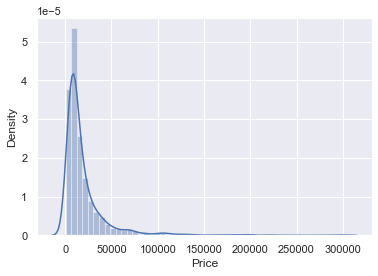

In [13]:
sns.distplot(data_no_missing_values['Price'])

/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Mileage', ylabel='Density'>

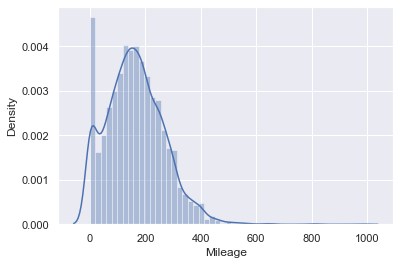

In [14]:
sns.distplot(data_no_missing_values['Mileage'])

/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='EngineV', ylabel='Density'>

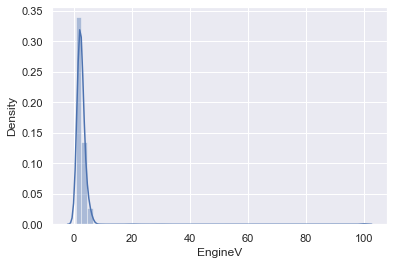

In [15]:
sns.distplot(data_no_missing_values['EngineV'])

/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year', ylabel='Density'>

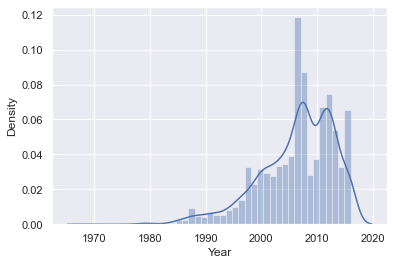

In [16]:
sns.distplot(data_no_missing_values['Year'])

### What if we don't clean up the data?

### Let's clean up the data with Quantile

In [17]:
# price 열을 정리한다.
# 99% 이하의 데이터가 정상 정규분포라고 보이니까 그 이하 데이터를 취한다.
q_rate = 0.99
q = data_no_missing_values['Price'].quantile(q_rate)
price_edited_data = data_no_missing_values[data_no_missing_values['Price']<q]

price_edited_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3984,3984.000000,3984,3984.000000,3984.000000,3984,3984,3984.000000,3984
unique,7,NaN,6,NaN,NaN,4,2,NaN,302
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,880,NaN,1528,NaN,NaN,1853,3613,NaN,188
mean,NaN,17837.117460,NaN,165.116466,2.743770,NaN,NaN,2006.292922,NaN
std,NaN,18976.268315,NaN,102.766126,4.956057,NaN,NaN,6.672745,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6980.000000,NaN,93.000000,1.800000,NaN,NaN,2002.750000,NaN
50%,NaN,11400.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21000.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000,NaN


/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

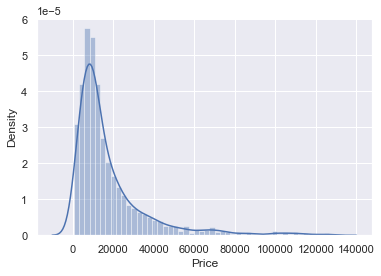

In [18]:
sns.distplot(price_edited_data['Price'])

In [19]:
# Mileage 열을 정리한다.
# 99% 이하의 데이터가 정상 정규분포라고 보이니까 그 이하 데이터를 취한다.
q_rate = 0.99
q = price_edited_data['Mileage'].quantile(q_rate)
price_mileage_edited_data = price_edited_data[price_edited_data['Mileage']<q]

price_mileage_edited_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3944,3944.000000,3944,3944.000000,3944.000000,3944,3944,3944.000000,3944
unique,7,NaN,6,NaN,NaN,4,2,NaN,299
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,867,NaN,1511,NaN,NaN,1825,3576,NaN,185
mean,NaN,17933.880822,NaN,161.484026,2.747612,NaN,NaN,2006.389959,NaN
std,NaN,19008.212025,NaN,96.027108,4.980406,NaN,NaN,6.595986,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,7000.000000,NaN,92.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21376.250000,NaN,230.000000,3.000000,NaN,NaN,2011.000000,NaN


/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Mileage', ylabel='Density'>

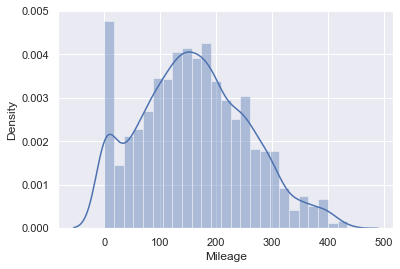

In [20]:
sns.distplot(price_mileage_edited_data['Mileage'])

In [21]:
threshold = 6.5
price_mileage_EngineV_edited_data = price_mileage_edited_data[price_mileage_edited_data['EngineV']<threshold]

/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='EngineV', ylabel='Density'>

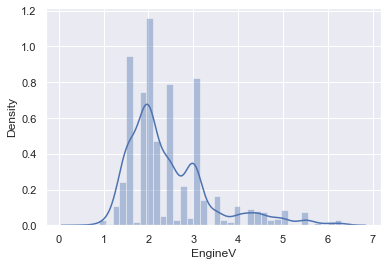

In [22]:
sns.distplot(price_mileage_EngineV_edited_data['EngineV'])

In [23]:
q_rate = 0.01
q = price_mileage_EngineV_edited_data['Year'].quantile(q_rate)
price_mileage_EngineV_Year_edited_data = price_mileage_EngineV_edited_data[price_mileage_EngineV_edited_data['Year']>q]

/Users/yongwoojeong/miniforge3/envs/eaglewatch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year', ylabel='Density'>

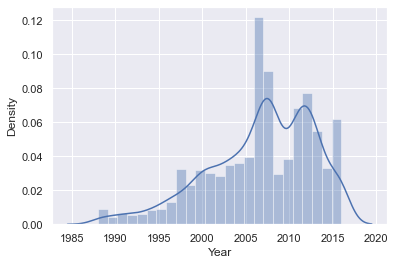

In [24]:
sns.distplot(price_mileage_EngineV_Year_edited_data['Year'])

## Index resetting

In [25]:
# 이제 인덱스를 다시 생성 및 정렬함
data_cleaned_but_not_scaled = price_mileage_EngineV_Year_edited_data.reset_index(drop=True)

## Scaling

In [26]:
scaler = StandardScaler()

In [27]:
x_label = ['EngineV', 'Mileage', 'Year']
y_label = 'Price'

### We will compare cleaned data (quantiled, less data) vs uncleaned data (more data)

In [28]:
data_no_missing_values = data_no_missing_values.reset_index(drop=True) # 여기도 인덱스 리셋

In [29]:
data_no_missing_values_ = data_no_missing_values.copy() # keep data_no_missing_values untouched.

In [30]:
data_quantiled = data_cleaned_but_not_scaled.copy() # keep data_cleaned untouched.

In [31]:
all_columns = x_label.copy()
all_columns.append(y_label)
all_columns

['EngineV', 'Mileage', 'Year', 'Price']

In [32]:
# scaling이 된 클린데이터 
data_quantiled = data_quantiled[all_columns]

In [33]:
data_quantiled.loc[:,:] = scaler.fit_transform(data_quantiled.values)
# store these off for predictions with unseen data
Xmeans = scaler.mean_
Xstds = scaler.scale_

In [34]:
data_quantiled

,EngineV,Mileage,Year,Price
0,-0.474525,1.217908,-2.574086,-0.733332
1,0.473599,2.786602,-1.263272,-0.539446
2,2.685886,2.065003,-0.607866,-0.256477
3,1.843110,0.830963,0.047541,0.251818
4,-0.474525,-0.423992,0.702948,0.005531
...,...,...,...,...
3862,0.052210,0.025700,0.211393,-0.350800
3863,-0.895913,-1.312919,1.194503,-0.015430
3864,0.578946,-1.584826,1.194503,5.596781
3865,1.105681,-1.668490,-1.263272,-0.612808


In [35]:
scaler_uncleaned = StandardScaler()

In [36]:
# scaling이 된 클린 안된 데이터 
data_raw_uncleaned = data_no_missing_values_[all_columns] 

In [37]:
data_raw_uncleaned.loc[:,:] = scaler_uncleaned.fit_transform(data_raw_uncleaned.values)
# store these off for predictions with unseen data
Xmeans_uncleaned = scaler_uncleaned.mean_
Xstds_uncleaned = scaler_uncleaned.scale_

/var/folders/gd/hqklq0l14kb2rs2wp0r1ypwr0000gn/T/ipykernel_21627/2498223302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw_uncleaned.loc[:,:] = scaler_uncleaned.fit_transform(data_raw_uncleaned.values)


In [38]:
data_raw_uncleaned

,EngineV,Mileage,Year,Price
0,-0.154921,1.097173,-2.297262,-0.594762
1,0.027438,2.548105,-1.102298,-0.451421
2,0.452941,1.880676,-0.504817,-0.242220
3,0.290845,0.739277,0.092665,0.133567
4,-0.154921,-0.421468,0.690147,-0.048516
...,...,...,...,...
4020,-0.235969,-1.243663,1.138259,-0.064012
4021,0.047700,-1.495158,1.138259,4.085136
4022,0.149010,-1.572541,-1.102298,-0.505658
4023,-0.154921,0.294325,-3.193485,-0.447547


In [39]:
x_label

['EngineV', 'Mileage', 'Year']

## First OLS
Quantile이 안된 data_raw_uncleaned과 Quantile이 된 data_raw를 비교함

In [40]:
# OLS 구동하기 
# 여기서 categorical 데이터는 일단 안쓰기로 함  
# Null 값만 빠지고 전혀 튜닝이 안된 데이터

x_raw = data_raw_uncleaned[x_label]
y_raw = data_raw_uncleaned[y_label]
x_raw_input = sm.add_constant(x_raw)
model_raw = sm.OLS(y_raw, x_raw_input)
uncleaned_results = model_raw.fit()

In [41]:
uncleaned_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     527.0
Date:                Thu, 05 Oct 2023   Prob (F-statistic):          8.31e-289
Time:                        14:29:16   Log-Likelihood:                -5043.9
No. Observations:                4025   AIC:                         1.010e+04
Df Residuals:                    4021   BIC:                         1.012e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.204e-16      0.013  -9.01e-15      1.000      -0.026       0.026
EngineV        0.0748      0.013      5.592      0.000       0.049       0.101
Mileage       -0.2706      0.018    -15.132      0.000      -0.306      -0.236
Year           0.3082      0.018     17.233      0.000       0.273       0.343
==============================================================================
Omnibus:                     3966.991   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           251794.400
Skew:                           4.733   Prob(JB):                         0.00
Kurtosis:                      40.574   Cond. No.                         2.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# Null 값 뿐만 아니라 데이터 전체가 refine이 된 데이터
x1 = data_quantiled[x_label]
y = data_quantiled[y_label]
x = sm.add_constant(x1)
model_refined = sm.OLS(y,x)
refined_results = model_refined.fit()

In [43]:
refined_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1458.
Date:                Thu, 05 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:29:24   Log-Likelihood:                -4023.2
No. Observations:                3867   AIC:                             8054.
Df Residuals:                    3863   BIC:                             8079.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.702e-15      0.011  -4.27e-13      1.000      -0.022       0.022
EngineV        0.4022      0.011     36.488      0.000       0.381       0.424
Mileage       -0.2914      0.016    -18.478      0.000      -0.322      -0.260
Year           0.3704      0.016     23.484      0.000       0.339       0.401
==============================================================================
Omnibus:                     2125.046   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20521.166
Skew:                           2.458   Prob(JB):                         0.00
Kurtosis:                      13.158   Cond. No.                         2.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Comparison result

1. 데이터가 4025 개에서 3867 로 약 158개, 전체에서 약 4% 줄었는데 성능향상이 월등.
2. Jarque-Bera (JB) 스코어가 251794.400 에서 20521.166 으로 12배 이상 줄어들어서 데이터가 전 보다 더 정규분포화 되었다고 말해준다.
3. Adj. R-squared 스코어가 0.282 에서 0.531 으로 늘어서 업데이트된 OLS 모델은 이 현상을 더 잘 설명해주었다.
4. F-statistic 스코어가 527. 에서 1458. 으로 늘어서 업데이트된 OLS 모델은 오차에 대한 영향이 더 줄어들었다.
5. AIC 스코어가 9.187e+04 에서 8.429e+04 으로 줄어들어서 이 OLS 모델은 데이터에 대한 예측정확도가 늘어났다.
6. Durbin-Watson 스코어가 2.031에서 2.055로 크게 변하지 않아서 이 OLS 모델은 아직도 auto correlation 이슈는 없다.

## Adj. R-squared가 0.531밖에 안되어서 예측 정확도가 낮아질 수 있음!!!!

In [44]:
def get_summary_stats(results, pval_limits=0.05):
    basic_scores = results.summary2().tables[0]
    advanced_scores = results.summary2().tables[2]
    
    # add any elements you need later
    data = {'R-squared' : [basic_scores[1][6]],
            'Adj_R-squared' : [basic_scores[3][0]], 
            'AIC' : [basic_scores[3][1]],
            'F-statistic' : [basic_scores[3][4]],
            'Durbin-Watson' : advanced_scores[3][0],
            'Jarque-Bera' : advanced_scores[3][1]
           }
    df = pd.DataFrame (data, columns=data)   
    
    # coefficients
    coeffs_list = results.summary2().tables[1]
    
    # list of effective coefficients
    newlist_without_const = list(coeffs_list[coeffs_list['P>|t|']<=pval_limits].index)
    newlist = newlist_without_const.copy()
    newlist.append('const') # add constant
    
    # effective coefficients
    df_coeffs = pd.DataFrame(coeffs_list['Coef.'][newlist])
    
    # flushing
    basic_scores = []
    advanced_scores = []
    results = []
    coeffs_list = []
    newlist = []
    data = []
    
    return df, df_coeffs, newlist_without_const   

In [45]:
scores, coeffs, newlist = get_summary_stats(refined_results)

## 아래 자료를 중간 리포트로 사용 가능

In [46]:
scores

,R-squared,Adj_R-squared,AIC,F-statistic,Durbin-Watson,Jarque-Bera
0,0.531,0.531,8054.4174,1458.,2.055,20521.166


In [47]:
coeffs

,Coef.
EngineV,4.021687e-01
Mileage,-2.914098e-01
Year,3.704228e-01
const,-4.702201e-15


In [48]:
newlist

['EngineV', 'Mileage', 'Year']

## 이제 VIF를 비교해본다, Multicollinearity
여기서 데이터가 scaler로 변환되어 있지 않으면 아래와 같은 증상이 나타난다

In [49]:
vif_max = 5
variables = data_cleaned_but_not_scaled[newlist]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns

vif_dangerous_list = vif[vif["VIF"]>vif_max]
vif_dangerous_list

# 대부분의 입력이 문제가 있는 것으로 나옴

,VIF,Features
0,7.662068,EngineV
2,10.354854,Year


## 이제 scaler로 scaling이 된 데이터를 가지고 같은 작업을 해보면 다르게 나타난다. 

In [50]:
vif_max = 5
variables = data_quantiled[newlist]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns

vif_dangerous_list = vif[vif["VIF"]>vif_max]
vif_dangerous_list

# 모든 입력이 문제가 없는 것으로 나옴

,VIF,Features


In [51]:
vif_safe_list = vif[vif["VIF"]<=vif_max]
vif_safe_list

,VIF,Features
0,1.000562,EngineV
1,2.048411,Mileage
2,2.049176,Year


In [52]:
# 데이터가 4025 개에서 3867 로 약 158개, 전체에서 약 4% 줄었는데 성능향상이 월등.

# Jarque-Bera (JB) 스코어가 251794.400 에서 20521.166 으로 12배 이상 줄어들어서 데이터가 전 보다 더 정규분포화 되었다고 말해준다.
# Adj. R-squared 스코어가 0.282 에서 0.531 으로 늘어서 업데이트된 OLS 모델은 이 현상을 더 잘 설명해주었다.
# F-statistic 스코어가 527. 에서 1458. 으로 늘어서 업데이트된 OLS 모델은 오차에 대한 영향이 더 줄어들었다.
# AIC 스코어가 9.187e+04 에서 8.429e+04 으로 줄어들어서 이 OLS 모델은 데이터에 대한 예측정확도가 늘어났다.
# Durbin-Watson 스코어가 2.031에서 2.055로 크게 변하지 않아서 이 OLS 모델은 아직도 auto correlation 이슈는 없다.


# 만약 전부다 VIF 스코어거 5 이하였다면 아래와 같이 진행할 것.

# 해당 OLS 선형 모델은 다음과 같이 선정된다.
# Price = const + coef of EngineV x EngineV + coef of Mileage x Mileage + coef of Year x Year

In [53]:
data_predicted = refined_results.predict() # 트레이닝 데이터 가지고 prediction

In [54]:
data_quantiled['Price']

0      -0.733332
1      -0.539446
2      -0.256477
3       0.251818
4       0.005531
          ...   
3862   -0.350800
3863   -0.015430
3864    5.596781
3865   -0.612808
3866   -0.245997
Name: Price, Length: 3867, dtype: float64

In [55]:
Xmeans.shape 

(4,)

In [56]:
Xstds.shape

(4,)

In [57]:
data_quantiled

,EngineV,Mileage,Year,Price
0,-0.474525,1.217908,-2.574086,-0.733332
1,0.473599,2.786602,-1.263272,-0.539446
2,2.685886,2.065003,-0.607866,-0.256477
3,1.843110,0.830963,0.047541,0.251818
4,-0.474525,-0.423992,0.702948,0.005531
...,...,...,...,...
3862,0.052210,0.025700,0.211393,-0.350800
3863,-0.895913,-1.312919,1.194503,-0.015430
3864,0.578946,-1.584826,1.194503,5.596781
3865,1.105681,-1.668490,-1.263272,-0.612808


In [58]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_predicted, data_quantiled['Price'])

In [59]:
mse

0.46903099911469975

In [60]:
data_predicted_rescaled = (data_predicted * Xstds[3]) + Xmeans[3]

data_predicted_rescaled

array([-10416.30002639,  -2597.30635707,  23027.32570147, ...,
        39894.91619836,  27028.91344237,  23963.42091967])

In [61]:
original_value = (data_quantiled['Price'] * Xstds[3]) + Xmeans[3]

original_value

0         4200.0
1         7900.0
2        13300.0
3        23000.0
4        18300.0
          ...   
3862     11500.0
3863     17900.0
3864    125000.0
3865      6500.0
3866     13500.0
Name: Price, Length: 3867, dtype: float64

In [62]:
df_comparison = pd.DataFrame() 

In [63]:
df_comparison['label'] = original_value

In [64]:
df_comparison['predicted'] = data_predicted_rescaled

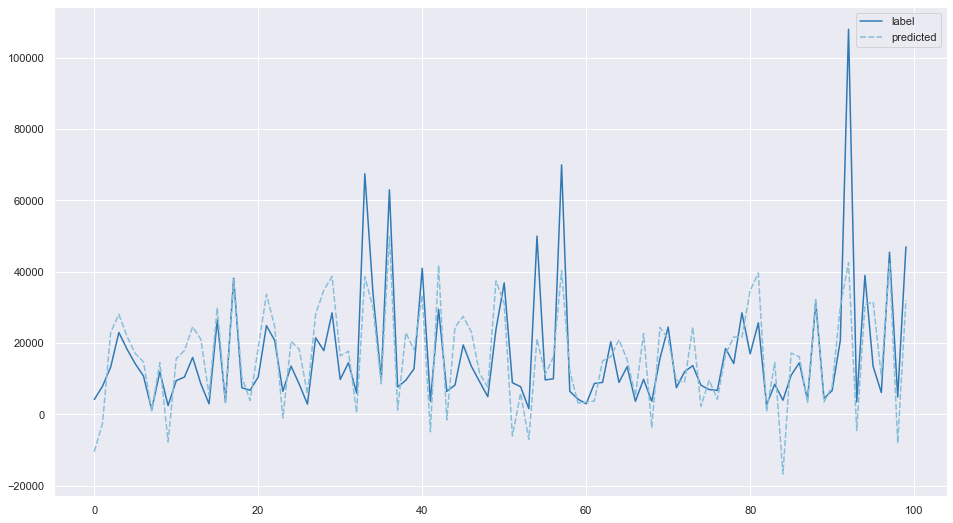

In [65]:
plt.figure(figsize=(16, 9))
sns.set_palette('RdBu_r')
ax = sns.lineplot(data=df_comparison[0:100])

이 현상은 현재 데이터 차트에서 categorical 데이터로 되어 있는 부분을 삭제하고 진행해서 
Adj. R-squared 0.531 인 상황 떄문일 수도 있음.